In [106]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from scipy.optimize import minimize
import warnings

warnings.filterwarnings("ignore")

In [107]:
# ==========================================
# 1. Todas las matemáticas y funciones
# ==========================================

def fit_garch_ewma_dcc(returns, lambda_corr=0.94):
    n_assets = returns.shape[1]
    latest_vols = []
    std_resids = pd.DataFrame(index=returns.index, columns=returns.columns)
    
    for col in returns.columns:
        am = arch_model(returns[col], vol='Garch', p=1, q=1, mean='Zero', dist='Normal')
        res = am.fit(disp='off')
        cond_vol = res.conditional_volatility
        std_resids[col] = returns[col] / cond_vol
        forecast = res.forecast(horizon=1)
        next_vol = np.sqrt(forecast.variance.iloc[-1].values[0])
        latest_vols.append(next_vol)

    D_next = np.diag(latest_vols)
    corr_dynamic = std_resids.ewm(alpha=(1 - lambda_corr), adjust=False).corr()
    R_next = corr_dynamic.iloc[-n_assets:].values 
    Cov_next = D_next @ R_next @ D_next
    return Cov_next

def get_expected_returns_js(returns, lookback=60):
    mu_sample = returns.tail(lookback).mean()
    mu_global = mu_sample.mean()
    phi = 0.5 
    mu_shrunk = (1 - phi) * mu_sample + phi * mu_global
    return mu_shrunk.values

def optimize_portfolio_sharpe(cov_matrix, expected_returns):
    n_assets = len(expected_returns)
    def objective(weights):
        port_ret = np.dot(weights, expected_returns)
        port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -(port_ret / port_vol) if port_vol > 0 else 0

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0.0, 1.0) for _ in range(n_assets))
    res = minimize(objective, [1./n_assets]*n_assets, method='SLSQP', bounds=bounds, constraints=constraints)
    return res.x

In [108]:
# ==========================================
# 2. CONFIGURACIÓN DEL BACKTEST
# ==========================================

TICKERS = ['F', 'PFE', 'HPE', 'BAC']
END_DATE = '2026-01-03'
START_DATE = '2024-07-15'

data = yf.download(TICKERS, start=START_DATE, end=END_DATE, auto_adjust=True)['Close']
returns = np.log(data / data.shift(1)).dropna()

# Definimos fechas de rebalanceo (fin de cada mes)
rebalance_dates = returns.resample('ME').last().index

port_returns = []
dates_list = []
weights_history = []

print("🚀 Iniciando Simulación de Rebalanceo Mensual...")

# ==========================================
# 3. LOOP DE SIMULACIÓN (VENTANA MÓVIL)
# ==========================================

for i in range(len(rebalance_dates)-1):
    current_date = rebalance_dates[i]
    next_date = rebalance_dates[i+1]
    
    # Ventana de entrenamiento (historia previa al rebalanceo)
    train_subs = returns.loc[:current_date].tail(252) # 1 año de lookback
    
    if len(train_subs) < 100: continue
        
    # Cálculo de parámetros
    try:
        cov_next = fit_garch_ewma_dcc(train_subs)
        mu_next = get_expected_returns_js(train_subs)
        w = optimize_portfolio_sharpe(cov_next, mu_next)
    except:
        w = np.array([1./len(TICKERS)]*len(TICKERS)) # Fallback a Equi-peso
    
    # Aplicar pesos al periodo siguiente
    period_returns = returns.loc[current_date:next_date]
    strat_ret = (period_returns * w).sum(axis=1)
    
    port_returns.append(strat_ret)
    dates_list.append(current_date)
    weights_history.append(w)

# Concatenar resultados
final_strategy_ret = pd.concat(port_returns)
cum_ret = (1 + final_strategy_ret).cumprod()

# Benchmark (S&P 500)
spy = yf.download('SPY', start=cum_ret.index[0], end=cum_ret.index[-1], auto_adjust=True)['Close']
spy_ret = spy.pct_change().dropna()
spy_cum = (1 + spy_ret).cumprod()

[*********************100%***********************]  4 of 4 completed


🚀 Iniciando Simulación de Rebalanceo Mensual...


[*********************100%***********************]  1 of 1 completed


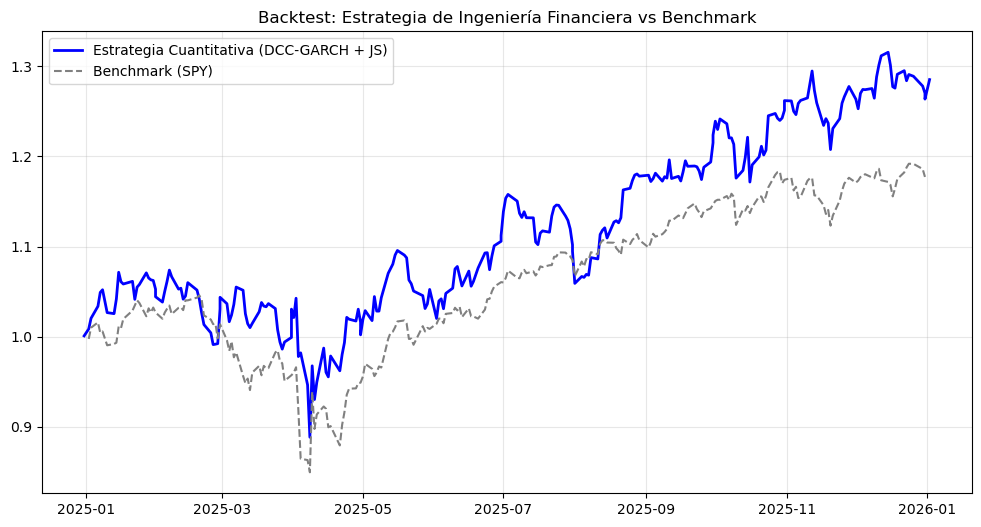


--- RESUMEN DE PERFORMANCE ---
Sharpe Ratio: 1.13
Max Drawdown: -17.26%
Retorno Total: 28.51%


In [109]:
# ==========================================
# 4. VISUALIZACIÓN Y MÉTRICAS
# ==========================================

plt.figure(figsize=(12,6))
plt.plot(cum_ret, label='Estrategia Cuantitativa (DCC-GARCH + JS)', color='blue', lw=2)
plt.plot(spy_cum, label='Benchmark (SPY)', color='gray', linestyle='--')
plt.title('Backtest: Estrategia de Ingeniería Financiera vs Benchmark')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Cálculo de Métricas Finales
sharpe = (final_strategy_ret.mean() * 252) / (final_strategy_ret.std() * np.sqrt(252))
drawdown = (cum_ret / cum_ret.cummax() - 1).min()

print(f"\n--- RESUMEN DE PERFORMANCE ---")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Max Drawdown: {drawdown:.2%}")
print(f"Retorno Total: {(cum_ret[-1]-1):.2%}")

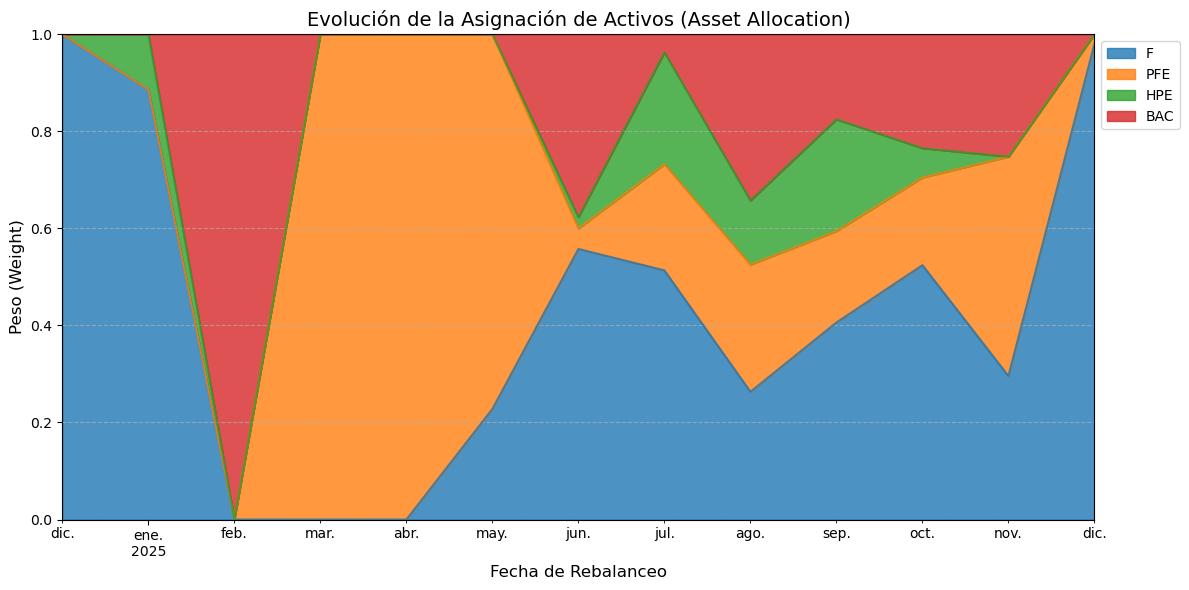

📊 Última asignación calculada:
F      0.9803
PFE    0.0197
HPE    0.0000
BAC    0.0000
Name: 2025-12-31 00:00:00, dtype: float64


In [110]:
# ==========================================
# 5. VISUALIZACIÓN DE LA EVOLUCIÓN DE PESOS
# ==========================================

# Convertimos el historial de pesos a un DataFrame para facilitar el manejo
df_weights = pd.DataFrame(weights_history, index=dates_list, columns=TICKERS)

# Graficamos
plt.figure(figsize=(12, 6))
df_weights.plot(kind='area', stacked=True, figsize=(12, 6), alpha=0.8, ax=plt.gca())

plt.title('Evolución de la Asignación de Activos (Asset Allocation)', fontsize=14)
plt.ylabel('Peso (Weight)', fontsize=12)
plt.xlabel('Fecha de Rebalanceo', fontsize=12)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.ylim(0, 1) # Aseguramos que el eje Y esté entre 0 y 100%
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Opcional: Mostrar los últimos pesos calculados
print("📊 Última asignación calculada:")
print(df_weights.iloc[-1].round(4))